# 2.2 Datasetの実装、 2.3 DataLoaderの実装

本ファイルでは、SSDなど物体検出アルゴリズム用のDatasetとDataLoaderを作成します。

VOC2012データセットを対象とします。


# 2.2 学習目標

1.	物体検出で使用するDatasetクラスを作成できるようになる
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する



# 2.3 学習目標

1.	物体検出で使用するDataLoaderクラスを作成できるようになる



# 事前準備


OpenCVのインストール

- pip install opencv-python

本書の指示に従い、VOC2010のデータセットをダウンロード

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/



In [2]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2, glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 画像データ、アノテーションデータへのファイルパスのリストを作成する(変更)

In [4]:
def make_datapath_list_ibem(rootpath):
    """
    「バウンディングボックスが存在する」データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    jpeg_path_template = osp.join(rootpath + "*.jpg")
    text_path_template = osp.join(rootpath + "*.txt")

    img_list = glob.glob(jpeg_path_template)
    anno_list = glob.glob(text_path_template)

    valid_index = []

    for i in range(len(anno_list)):
        txt_path = anno_list[i]

        with open(txt_path, mode='rt') as f:
            anno_data = f.readlines()
        
        if(len(anno_data) > 4):
            valid_index.append(i)

    valid_img_list = []
    valid_anno_list =  []
    for j in valid_index:
        valid_img_list.append(img_list[j])
        valid_anno_list.append(anno_list[j])

    return valid_img_list, valid_anno_list


In [5]:
train_rootpath = "./data/IBEMdataset/Tr00/"
train_img_list, train_anno_list = make_datapath_list_ibem(train_rootpath)
val_rootpath = "./data/IBEMdataset/Va00/"
val_img_list, val_anno_list = make_datapath_list_ibem(val_rootpath)

# 動作確認
print(len(train_img_list))
print(len(train_anno_list))
print(train_img_list[0])


3666
3666
./data/IBEMdataset/Tr00\0001015-page01.jpg


# txt形式のアノテーションデータをリストに変換する（変更）

In [6]:
# 「txt形式のアノテーション」を、リスト形式に変換するクラス


class Anno_txt2list(object):
    """
    1枚の画像に対する「txt形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, txt_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分だけ要素を持つ。
        """

        # txtファイルを読み込む
        with open(txt_path, mode='rt') as f:
            anno_data = f.readlines()
        
        if(len(anno_data)==4):
            ret = [[0, 0, 0, 0, -1]]
        
        else:
            ret = []

            for i in range(4, len(anno_data)):
                bndbox = anno_data[i].replace(' ', '').replace('\n', '').split("\t")
                for j in range(len(bndbox)):
                    bndbox[j] = float(bndbox[j])

                # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
                bbox_xywh = bndbox[:4]
                xmin = bbox_xywh[0]
                ymin = bbox_xywh[1]
                xmax = xmin + bbox_xywh[2]
                ymax = ymin + bbox_xywh[3]

                # アノテーションのクラスを追加(Inline:0, Display:1)
                bndbox = [xmin/100, ymin/100, xmax/100, ymax/100, int(bndbox[4])]

                ret += [bndbox]
            
        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [7]:
# 動作確認　
classes = [0, 1]

transform_anno = Anno_txt2list(classes)

# 画像の読み込み OpenCVを使用
for ind in range(20):
    image_file_path = train_img_list[ind]
    img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
    height, width, channels = img.shape  # 画像のサイズを取得

    # アノテーションをリストで表示
    transform_anno(train_anno_list[ind], width, height)


# 画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [8]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)


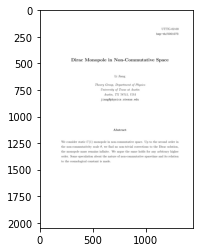

c:\Users\kwmrs\Documents\studies\SSD_IBEM_300\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


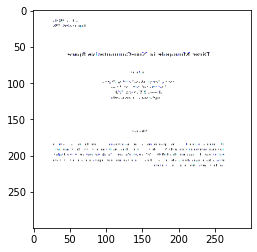

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


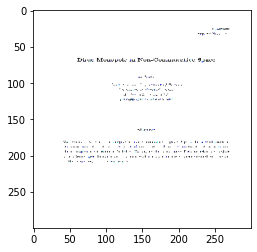

In [9]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[6]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_txt2list(classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# Datasetを作成する（変更：動作確認）

In [10]:
# IBEM datasetのDatasetを作成する


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをtxtからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [11]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_txt2list(classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_txt2list(classes))


# データの取り出し例
train_dataset.__getitem__(6)


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 array([[0.6433974 , 0.71417891, 0.65468566, 0.72465205, 0.        ],
        [0.62696302, 0.73067769, 0.62984042, 0.73806627, 0.        ]]))

# DataLoaderを作成する

In [12]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets


In [13]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数


torch.Size([4, 3, 300, 300])
4
torch.Size([14, 5])


In [14]:
print(train_dataset.__len__())
print(val_dataset.__len__())


3666
515


以上